In [181]:
%config Autocompleter.use_jedi=False

#### Feature Description:
    - Item_Identifier: Unique product ID
    - Item_Weight: Weight of product
    - Item_Fat_Content: Whether the product is low fat or not 
    - Item_Visibility: The % of total display area of all products in a store allocated to the particular product 
    - Item_Type: The category to which the product belongs 
    - Item_MRP: Maximum Retail Price (list price) of the product 
    - Outlet_Identifier: Unique store ID 
    - Outlet_Establishment_Year: The year in which store was established 
    - Outlet_Size: The size of the store in terms of ground area covered 
    - Outlet_Location_Type: The type of city in which the store is located 
    - Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket 
    - Item_Outlet_Sales: Sales of  the product in the particulat store. This is the outcome variable to be predicted. 


# 0. Importing libraries

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore,boxcox,probplot
import seaborn as sns
from statsmodels.api import OLS
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from catboost import CatBoostRegressor, CatBoostClassifier
from category_encoders import LeaveOneOutEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,classification_report,confusion_matrix
import warnings
from joblib import dump,load

warnings.filterwarnings('ignore')

In [183]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [184]:
train_df.head()

,id,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# 1. Data Inspection
    - Summary of dataset
    - Checking for Null Values, Data Type of Features

In [185]:
train_df.describe()

,id,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8525.000000,7062.000000,8525.000000,8525.000000,8525.000000,8525.000000
mean,4262.000000,12.858429,0.066119,140.988934,1997.831906,2181.236413
std,2461.099856,4.643833,0.051599,62.268794,8.370793,1706.306944
min,0.000000,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,2131.000000,8.775000,0.026980,93.843600,1987.000000,834.913200
50%,4262.000000,12.600000,0.053925,142.947000,1999.000000,1794.331000
75%,6393.000000,16.850000,0.094567,185.626600,2004.000000,3101.296400
max,8524.000000,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [186]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8525 entries, 0 to 8524
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         8525 non-null   int64  
 1   Item_Identifier            8525 non-null   object 
 2   Item_Weight                7062 non-null   float64
 3   Item_Fat_Content           8525 non-null   object 
 4   Item_Visibility            8525 non-null   float64
 5   Item_Type                  8525 non-null   object 
 6   Item_MRP                   8525 non-null   float64
 7   Outlet_Identifier          8525 non-null   object 
 8   Outlet_Establishment_Year  8525 non-null   int64  
 9   Outlet_Size                6115 non-null   object 
 10  Outlet_Location_Type       8525 non-null   object 
 11  Outlet_Type                8525 non-null   object 
 12  Item_Outlet_Sales          8525 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage:

<h3><u>Observation:</u></h3>
    
#### Irrelevant columns are present which can be removed:
    1. Item_Identifier
    2. Outlet_Identifer (Can be useful in grouping and getting some other informations)
    3. Outlet_Establishment_Year (can be useful to draw some informataion or to do feature engineering)

#### Some columns are categorical which needs to be encoded further:
    1. Item_Fat_Content
    2. Item_Type
    3. Outlet_Size
    4. Outlet_Location_Type
    5. Outlet_Type

In [187]:
print('----------------% of missing Values in train set---------------------------- ')
np.round(train_df.isna().sum()/len(train_df) * 100,2)

----------------% of missing Values in train set---------------------------- 


id                            0.00
Item_Identifier               0.00
Item_Weight                  17.16
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.27
Outlet_Location_Type          0.00
Outlet_Type                   0.00
Item_Outlet_Sales             0.00
dtype: float64

In [188]:
print('----------------% of missing Values in test set---------------------------- ')
np.round(test_df.isna().sum()/len(test_df) * 100,2)

----------------% of missing Values in test set---------------------------- 


Item_Identifier               0.00
Item_Weight                  17.18
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.27
Outlet_Location_Type          0.00
Outlet_Type                   0.00
dtype: float64

<h3><u>Observation:</u></h3>

#### We can see 2 features have the missing values both in train and test dataset which needs to be handled:
    1. Item_Weight
    2. Outlet_Size
    
<b>Note:</b> There can be more missing features, but will have to look for it.

# 2. Data Cleaning
    - Handling Missing Data
    - Removing redundant and duplicate data
    - Handling untidy dataset etc

## 2.1 Handling Missing Data

#### Types of Missing Values:
    - NaN
    - 0 (depends on feature)
    - -1, -9,-99,-999 etc

#### Features with missing values:
    1. Item_Weight
    2. Outlet_Size
    
#### Techniques to handle missing values:
    1. Impute with (Mean, Median) -- good for continous feature
    2. Frequency based imputation (Mode)       -- good for categorical feature
    3. Deleting the NaN rows
    4. imputation based on predictions
    5. Regression Imputation  -- Good if feature is highly correlated
    6. KNN based imputation

In [189]:
wt_miss_val = train_df['Item_Weight'].isna().sum()
print('Total missing value for Item_Weight is {} out of {}'.format(wt_miss_val,len(train_df['Item_Weight'])))

Total missing value for Item_Weight is 1463 out of 8525


In [190]:
size_miss_val = train_df['Outlet_Size'].isna().sum()
print('Total missing value for Outlet_Size is {} out of {}'.format(size_miss_val,len(train_df['Outlet_Size'])))

Total missing value for Outlet_Size is 2410 out of 8525


<AxesSubplot:xlabel='Item_Weight'>

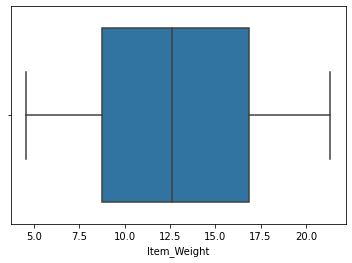

In [191]:
sns.boxplot(train_df['Item_Weight'])

It seems like outlier is not present in this feature so, we can replace the missing values with <b>mean</b> imputation.

In [192]:
# imputing Missing Value for Item_Weight with Mean
train_df['Item_Weight'].fillna(train_df['Item_Weight'].mean(),inplace=True)
test_df['Item_Weight'].fillna(test_df['Item_Weight'].mean(),inplace=True)

In [193]:
# imputing missing value for Outlet_Size based on frequency -- Medium here
print(train_df['Outlet_Size'].value_counts())

Medium    2794
Small     2389
High       932
Name: Outlet_Size, dtype: int64


In [194]:
# train_df['Outlet_Size'].fillna(train_df['Outlet_Size'].mode()[0],inplace=True)
# test_df['Outlet_Size'].fillna(test_df['Outlet_Size'].mode()[0],inplace=True)

In [195]:
train_df['Item_Visibility'].value_counts()

0.000000    526
0.076975      3
0.107037      2
0.061271      2
0.046825      2
           ... 
0.056387      1
0.013957      1
0.110460      1
0.124646      1
0.013496      1
Name: Item_Visibility, Length: 7882, dtype: int64

#### Observation:
    We can see that it has 0 values which is not possible in this case as, visibility of item in a store cannot be zero. So need to handle it.

In [196]:
per_missing_visib_train = len(train_df[train_df['Item_Visibility']==0])/len(train_df) * 100
per_missing_visib_test = len(test_df[test_df['Item_Visibility']==0])/len(test_df) * 100
print('Percent of missing values in Train->Item_Visibility are: {}%'.format(round(per_missing_visib_train,2)))
print('Percent of missing values in Test->Item_Visibility are: {}%'.format(round(per_missing_visib_test,2)))

Percent of missing values in Train->Item_Visibility are: 6.17%
Percent of missing values in Test->Item_Visibility are: 6.21%


<AxesSubplot:xlabel='Item_Visibility'>

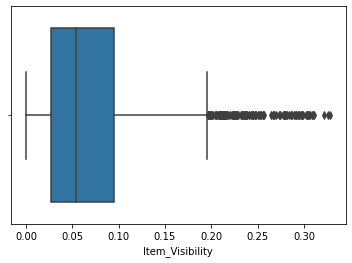

In [197]:
sns.boxplot(train_df['Item_Visibility'])

In [198]:
# Imputing Item_Visibility missinng values with Median
train_df['Item_Visibility'].replace({0:train_df['Item_Visibility'].median()},inplace=True)
test_df['Item_Visibility'].replace({0:test_df['Item_Visibility'].median()},inplace=True)

## 2.2 Removing redundant and duplicate data

#### Feature having duplicate data values:
    - Item_Fat_Content

In [199]:
# Get all categorical features
[x for x in train_df.select_dtypes('object').columns]

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [200]:
train_df['Outlet_Type'].value_counts()

Supermarket Type1    5579
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [201]:
train_df['Item_Fat_Content'].value_counts()

Low Fat    5090
Regular    2890
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

#### We can convert these multiple duplicate values to single as they denotes the same meaning
    - low fat, LF -> Low Fat & reg -> Regular

In [202]:
train_df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)
test_df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)
print(train_df['Item_Fat_Content'].value_counts())

Low Fat    5518
Regular    3007
Name: Item_Fat_Content, dtype: int64


# 3. EDA

    - Finding Correlations
    - Checking For multicolinearity
    - Univariate, Bivariate  Multivariate Analysis
    - Understanding about each and every features/columns/variables

## 3.1 Checking Correlation & Multicolinearity

<AxesSubplot:>

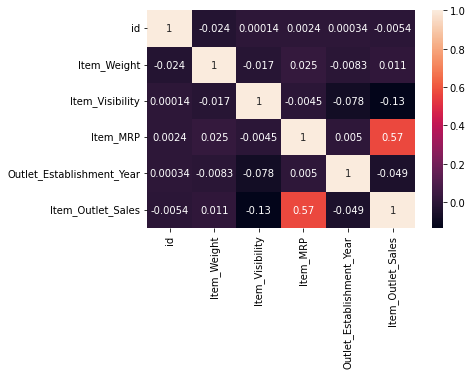

In [203]:
sns.heatmap(train_df.corr(),annot=True)

                        (Fig.- Correlation Heatmap for train data)

#### From this correlation heatmap it can be infered that there is no multicolinearity present.

In [204]:
# sns.pairplot(train_df,hue='Outlet_Type')

#### Some features are skewed which needs to be transformed (* if we use linear model else we can leave as it is):
    1. Item_Outlet_Sales (right skewed)
    2. Item_Visibility (right skewed)

#### From this diagram it can be inferred that:
    1. Overall Sales from all outlets  -> Supermarket Type1 > Supermarket Type3  > Grocery Store > Supermarket Type2
    2. Overall sales 
    3. Less sales from grocery store
    4. Outlet Establishments (earlier to later) => Supermarket Type3 -> Supermarket Type1 -> Grocery Store -> 
       Supermarket Type2
    

In [205]:
# sales_skewness = train_df['Item_Outlet_Sales'].skew()
# visibility_skewness = train_df['Item_Visibility'].skew()
# print('Skewness for Item_Outlet_Sales is {} and for Item_Visibility is {}'.format(sales_skewness,visibility_skewness))

#### From this it seems like these 2 features are highly skewed (>1), which can lead to unreliable results. So we need to transform it using either of these methods:
    1. Log transform (most preferred) -- We are going to use this over here
    2. Sqrt transform (generally less preferred)
    3. box-cox transform

In [206]:
# Applying log transform to both skewed feature
# train_df['Log_Item_Visibility'] = np.sqrt(train_df['Item_Visibility'])
# train_df['Log_Item_Outlet_Sales'] = np.log(train_df['Item_Outlet_Sales'])

# train_df.drop(columns=['Item_Visibility','Item_Outlet_Sales'],axis=1,inplace=True)

In [207]:
# sns.pairplot(train_df,hue='Outlet_Type')

#### After transforming the skewed data it can be inferred that:
    1. There is a positive correlation between MRP and sales.

In [208]:
# sns.heatmap(train_df.corr(),annot=True)

<center><b>Correlation after feature transformation</b></center>

## 3.2 Univariate Analysis

<AxesSubplot:xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

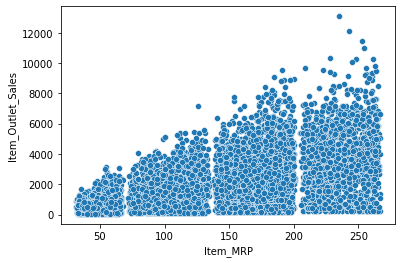

In [209]:
sns.scatterplot(x=train_df['Item_MRP'],y=train_df['Item_Outlet_Sales'])

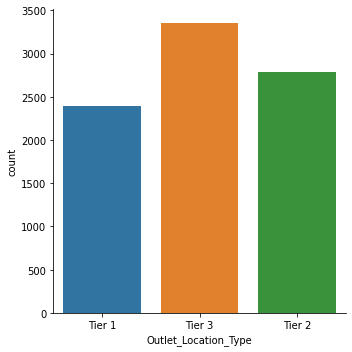

In [210]:
sns.catplot('Outlet_Location_Type',data=train_df,kind='count')

1. More no. of outlet in Tier 3 cities

<AxesSubplot:xlabel='Item_Type', ylabel='count'>

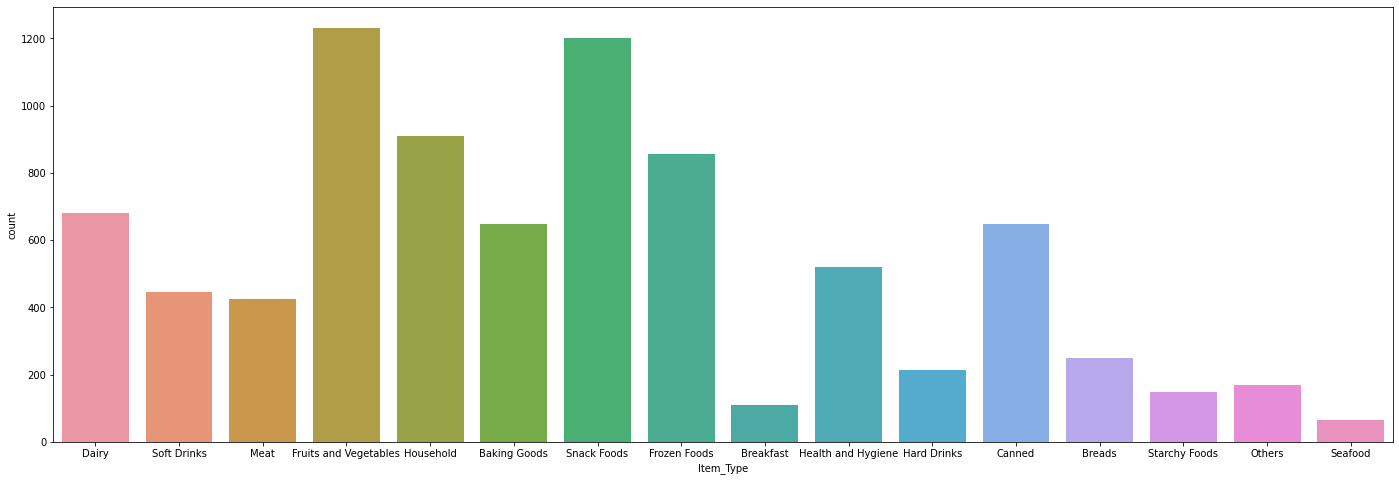

In [211]:
fig,ax = plt.subplots(figsize=(24,8))
sns.countplot(train_df['Item_Type'],ax=ax)

1. Fruits & vegetables are purchased more than others as it is of daily use.
2. Snack Foods also has high sales

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

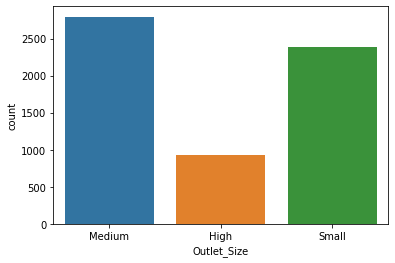

In [212]:
sns.countplot(train_df['Outlet_Size'])

1. Maximum outlet are of medium size

## 3.3 Bivariate Analysis

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

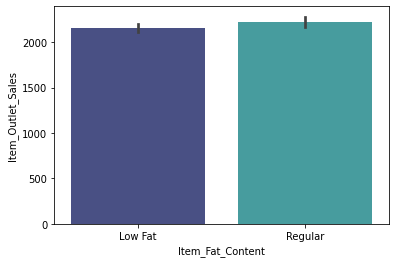

In [213]:
sns.barplot('Item_Fat_Content','Item_Outlet_Sales',data=train_df,palette='mako')

In [214]:
train_df.groupby(by='Outlet_Type')[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.052567
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


#### Outlet Type Vs Avg Sales

In [215]:
train_df.groupby(by='Outlet_Size')[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Size,
High,2298.995256
Medium,2681.257014
Small,1912.270324


#### Outlet Size Vs Avg Sales

In [216]:
train_df.groupby(by='Outlet_Location_Type')[['Item_Outlet_Sales']].mean()

,Item_Outlet_Sales
Outlet_Location_Type,
Tier 1,1876.976604
Tier 2,2323.990559
Tier 3,2279.627651


#### Outlet Location Type Vs Avg Sales

# 4. Feature Engineering

    - Handling Outliers
    - Handling irrelevant columns
    - Feature Encoding (handling categorical data)
    - Feature Generation
    - Selecting top/important features

## 4.1 Handling Outliers

<b>Note: </b> Outliers must be treated if we use linear model. 

#### Ways to treat outliers:
    1. Trimming/removing the outlier
    2. Quantile based flooring and capping
    3. Mean/Median imputation

## 4.2 Feature Encoding


#### Feature that needs to be encoded:

    1. Item_Fat_Content
    2. Item_Type
    3. Outlet_Size
    4. Outlet_Location_Type
    5. Outlet_Type 
    
#### Feature Encoding Techniques:
    1. Binary Encoding -> Item_Fat_Content
    2. Ordinal Encoding -> Outlet_Size, Outlet_Location_Type
    3. Nominal Encoding -> Outlet_Type, Item_Type, Outlet_Identifier
    4. Frequency Encoding
    
**  Item_Type is having large unique values

#### For Item_Type we will try grouping up some of the values to reduce unique values count:
    1. Drinks -> Soft Drinks, Hard Drinks
    2. Baking Goods -> Breads
    3. Meat -> Seafood


In [217]:
out_id_count = len(train_df['Outlet_Identifier'].unique())
print('Total Unique Values in Outlet Identifier is {}'.format(out_id_count))

Total Unique Values in Outlet Identifier is 10


In [218]:
train_df['Item_Type'].replace({'Soft Drinks':'Drinks','Hard Drinks':'Drinks','Breads':'Baking Goods','Seafood':'Meat'},inplace=True)
test_df['Item_Type'].replace({'Soft Drinks':'Drinks','Hard Drinks':'Drinks','Breads':'Baking Goods','Seafood':'Meat'},inplace=True)

In [219]:
#Binary Encoding

train_df['Item_Fat_Content'].replace({'Low Fat':0,'Regular':1},inplace=True)
test_df['Item_Fat_Content'].replace({'Low Fat':0,'Regular':1},inplace=True)

In [220]:
#One_hot encoding nominal variables

def one_hot(df,columns,prefixes):
    df = df.copy()
    for column,prefix in zip(columns,prefixes):
        dummies = pd.get_dummies(df[column],prefix=prefix,drop_first=True)
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(column,axis=1)
    return df

In [221]:
lEncIT = LabelEncoder()
lEncOT = LabelEncoder()

train_df['Outlet_Type'] = lEncOT.fit_transform(train_df['Outlet_Type'])
train_df['Item_Type'] = lEncIT.fit_transform(train_df['Item_Type'])
test_df['Outlet_Type'] = lEncOT.fit_transform(test_df['Outlet_Type'])
test_df['Item_Type'] = lEncIT.fit_transform(test_df['Item_Type'])

dump(lEncIT,'../models/lEncIT.pkl')
dump(lEncOT,'../models/lEncOT.pkl')


['../models/lEncOT.pkl']

In [222]:
train_df

#Label Encoding nominal Values
# enc = LabelEncoder()
# train_df['Outlet_Type'] = enc.fit_transform(train_df['Outlet_Type'])
# train_df['Item_Type'] = enc.fit_transform(train_df['Item_Type'])
# test_df['Outlet_Type'] = enc.fit_transform(test_df['Outlet_Type'])
# test_df['Item_Type'] = enc.fit_transform(test_df['Item_Type'])

,id,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,FDA15,9.30,0,0.016047,3,249.8092,OUT049,1999,Medium,Tier 1,1,3735.1380
1,1,DRC01,5.92,1,0.019278,4,48.2692,OUT018,2009,Medium,Tier 3,2,443.4228
2,2,FDN15,17.50,0,0.016760,9,141.6180,OUT049,1999,Medium,Tier 1,1,2097.2700
3,3,FDX07,19.20,1,0.053925,6,182.0950,OUT010,1998,NaN,Tier 3,0,732.3800
4,4,NCD19,8.93,0,0.053925,8,53.8614,OUT013,1987,High,Tier 3,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8520,8520,NCJ29,10.60,0,0.035186,7,85.1224,OUT035,2004,Small,Tier 2,1,1193.1136
8521,8521,FDN46,7.21,1,0.145221,11,103.1332,OUT018,2009,Medium,Tier 3,2,1845.5976
8522,8522,DRG01,14.80,0,0.044878,4,75.4670,OUT046,1997,Small,Tier 1,1,765.6700
8523,8523,FDW58,20.75,0,0.007565,11,107.8622,OUT049,1999,Medium,Tier 1,1,1713.4050


In [223]:
train_df['Item_Type'].unique()

array([ 3,  4,  9,  6,  8,  0, 11,  5,  1,  7,  2, 12, 10])

In [224]:
nominal_features = ['Outlet_Type','Item_Type']
prefixes = ['out_type','item_type']

# train_df = one_hot(train_df,nominal_features,prefixes)
# test_df = one_hot(test_df,nominal_features,prefixes)

In [225]:
#Ordinal Encoding

def ord_enc(df,col,ord_var):
    df = df.copy()
    df[col].replace(ord_var,inplace=True)
    return df

In [226]:
#Encoding Ordinal columns

outlet_size_ord = {'Small':0,'Medium':1,'High':2}
out_loc_ord = {'Tier 1':2,'Tier 2':1,'Tier 3':0}

train_df = ord_enc(train_df,'Outlet_Size',outlet_size_ord)
test_df = ord_enc(test_df,'Outlet_Size',outlet_size_ord)

train_df = ord_enc(train_df,'Outlet_Location_Type',out_loc_ord)
test_df = ord_enc(test_df,'Outlet_Location_Type',out_loc_ord)

## 4.3 Removing irrelevant columns

#### Irrelevant Columns in this dataset are: 
    1. Item_Identifier
    2. Outlet_Identifier (Can be left unremoved as it has not all unique values)

In [227]:
train_df.drop(columns=['Item_Identifier','Outlet_Identifier','id'],axis=1,inplace=True) #
test_df.drop(columns=['Item_Identifier','Outlet_Identifier'],axis=1,inplace=True)

In [228]:
cat_feature_count = len(train_df.select_dtypes('object').count())
print('Total Categorical Features present : {}'.format(cat_feature_count))

Total Categorical Features present : 0


## 4.4 Feature Generation

In [229]:
# Deriving new column called Years_Since_Established from Establishment Year

train_df['Years_Since_Established'] = train_df['Outlet_Establishment_Year'].apply(lambda x: 2021 - x) 
test_df['Years_Since_Established'] = test_df['Outlet_Establishment_Year'].apply(lambda x: 2021 - x)

### 4.x Imputing missing values for Outlet_size using Classification Algo 

**We can see a little bit of performance improvement after Imputing missing values by predcting using CatBoost Algortithm

In [230]:
out_train_pred_df = train_df[train_df['Outlet_Size'].isna()]
out_test_pred_df =  test_df[test_df['Outlet_Size'].isna()]
out_train_df = train_df[~train_df['Outlet_Size'].isna()] #for training
out_train_df.isna().sum()
# out_train_df['Outlet_Size'] = out_train_df['Outlet_Size'].replace({'Small':0,'Medium':1,'High':2})
# out_train_df.drop(columns=['Item_Identifier','Outlet_Identifier'],inplace=True)
X = out_train_df.drop(columns=['Outlet_Size','Item_Outlet_Sales'])
y = out_train_df['Outlet_Size']
print(y.unique())
trainX,testX,trainY,testY = train_test_split(X,y,random_state=22,test_size=0.2)
cat_model = RandomForestClassifier(random_state=2)
cat_model.fit(trainX,trainY)

[1. 2. 0.]


RandomForestClassifier(random_state=2)

In [231]:
pred = cat_model.predict(testX)

In [232]:
out_train_pred = cat_model.predict(out_train_pred_df.drop(columns=['Outlet_Size','Item_Outlet_Sales']))

In [233]:
out_train_pred_df['Outlet_Size'] = out_train_pred

In [234]:
out_test_pred = cat_model.predict(out_test_pred_df.drop(columns=['Outlet_Size']))
out_test_pred_df['Outlet_Size'] = out_test_pred

In [235]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [236]:
train_df = pd.concat([train_df,out_train_pred_df])
test_df = pd.concat([test_df,out_test_pred_df])

# 5. Splitting & Training Model

    1. Scaling
    2. Splitting
    3. Training

In [237]:
X = train_df.drop(columns=['Item_Outlet_Sales'],axis=1)
y = train_df['Item_Outlet_Sales']

In [238]:
# Scaling the feature
scale = StandardScaler()

In [239]:
trainX,testX,trainY,testY = train_test_split(X,y,random_state=42,test_size=0.25)

In [240]:
# trainX['Log_Item_Visibility'] = trainX['Log_Item_Visibility']**-1/2
# trainY = np.exp(trainY)
# testX['Log_Item_Visibility'] = testX['Log_Item_Visibility']**-1/2
# testY = np.exp(testY)

In [241]:
model_acc_scores = {}
def predictionResult(testY,pred,model_name,model):
    print('------------------Test Result---------------')
    print('--------------------{}------------------'.format(model_name))
    score = r2_score(testY,pred)
    mae = mean_absolute_error(testY,pred)
    mse = mean_squared_error(testY,pred)
    rmse = np.sqrt(mse)
    scores_dict = {'R2 Score':score,'Mean Absolute Error':mae,'Mean Squared Error':mse,'Root Mean Squared Error':rmse}
    model_acc_scores[model_name] = scores_dict
    print('R Squared Score is: {}'.format(score))
    print('Mean Absolute Error is: {}'.format(mae))
    print('Mean Squared Error is: {}'.format(mse))
    print('Root Mean Squared Error is: {}'.format(rmse))
    cv_score = cross_val_score(model,trainX,trainY,cv=5)
    print('------CV Score-------')
    print('CV Score for {} model is {}'.format(model_name,cv_score.mean()))
    print(sns.residplot(pred.reshape(-1),testY,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1}))
    
    plt.xlabel("Fitted values")
    plt.title('Residual plot')

    #Q-Q Plot
    residuals = testY - pred.reshape(-1)
    # residuals

    plt.figure(figsize=(7,7))
    print(probplot(residuals, dist="norm", plot=plt))
    plt.title("Normal Q-Q Plot")

------------------Test Result---------------
--------------------LinearRegression------------------
R Squared Score is: 0.5017659896480906
Mean Absolute Error is: 892.080920825516
Mean Squared Error is: 1380478.140325565
Root Mean Squared Error is: 1174.9375048595414
------CV Score-------
CV Score for LinearRegression model is 0.49778140087372014
AxesSubplot(0.125,0.125;0.775x0.755)
((array([-3.40979126, -3.15993193, -3.02141222, ...,  3.02141222,
        3.15993193,  3.40979126]), array([-3425.3596, -3135.5536, -3051.3104, ...,  4787.0688,  4931.5964,
        5006.7992])), (1167.609572665571, 15.348295872420145, 0.9924308354083818))


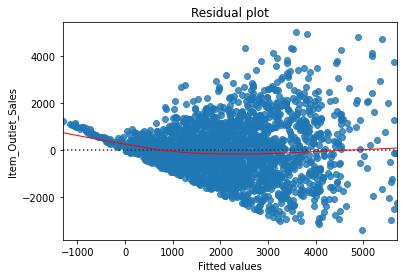

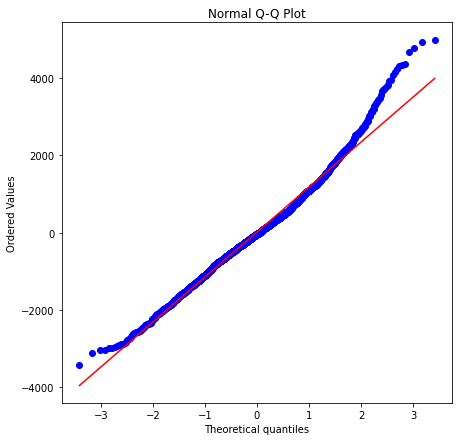

In [242]:
model_lin_reg = LinearRegression()

model_lin_reg.fit(trainX,trainY)

pred = model_lin_reg.predict(testX)
model_name = 'LinearRegression'

predictionResult(testY,pred,model_name,model_lin_reg)


Trining R2 Score: 0.620830030374188
------------------Test Result---------------
--------------------RandomForestRegressor------------------
R Squared Score is: 0.6113943392281034
Mean Absolute Error is: 736.5747521015635
Mean Squared Error is: 1076726.214502027
Root Mean Squared Error is: 1037.654188302648
------CV Score-------
CV Score for RandomForestRegressor model is 0.5882596934528305
AxesSubplot(0.125,0.125;0.775x0.755)
((array([-3.40979126, -3.15993193, -3.02141222, ...,  3.02141222,
        3.15993193,  3.40979126]), array([-4160.85980754, -4042.45582763, -3617.96410856, ...,
        4475.16909182,  4730.12582178,  4821.93704044])), (1021.7790063432623, 10.77084319472059, 0.9833498170181652))


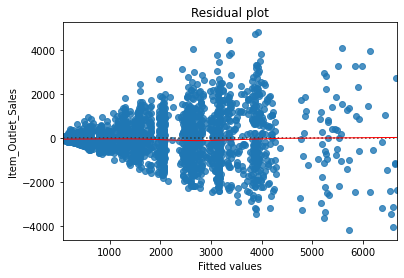

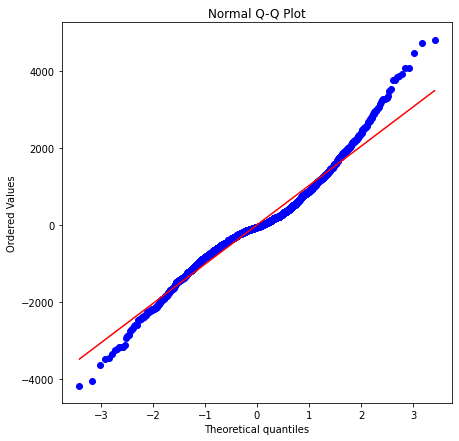

In [243]:
model_rf_reg = RandomForestRegressor(n_estimators=350,max_depth=6,random_state=2)
model_rf_reg.fit(trainX,trainY)

print('Trining R2 Score: {}'.format(model_rf_reg.score(trainX,trainY)))

pred = model_rf_reg.predict(testX)
model_name = 'RandomForestRegressor'

predictionResult(testY,pred,model_name,model_rf_reg)

Trining R2 Score: 0.6193481833467152
------------------Test Result---------------
--------------------CatBoostRegressor------------------
R Squared Score is: 0.618608557260963
Mean Absolute Error is: 729.5582359071336
Mean Squared Error is: 1056737.4740969494
Root Mean Squared Error is: 1027.9773704206477
------CV Score-------
CV Score for CatBoostRegressor model is 0.5920160750388979
AxesSubplot(0.125,0.125;0.775x0.755)
((array([-3.40979126, -3.15993193, -3.02141222, ...,  3.02141222,
        3.15993193,  3.40979126]), array([-4212.33945872, -3664.56789735, -3409.86375554, ...,
        4519.21830946,  4716.19036942,  4906.82331281])), (1010.7860843242189, 3.4806958662918164, 0.9818801972749024))


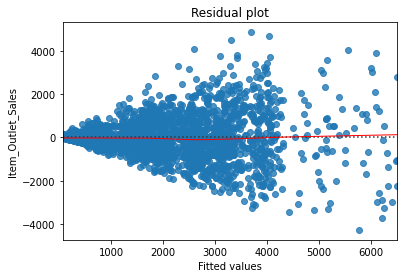

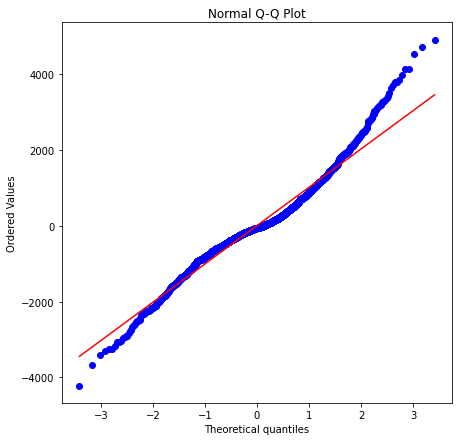

In [244]:
model_cat_reg = CatBoostRegressor(random_state=2,iterations=3000,learning_rate=0.002,depth=6,silent=True)
model_cat_reg.fit(trainX,trainY)

print('Trining R2 Score: {}'.format(model_cat_reg.score(trainX,trainY)))

pred = model_cat_reg.predict(testX)
model_name = 'CatBoostRegressor'

predictionResult(testY,pred,model_name,model_cat_reg)

## Hyperparameter Tuning

#### Method used to perform Hyperparamter Tuning:
    1. GridSearchCV
    2. RandomizedSearchCV
    3. Coordinate Descent and etc

In [245]:
def randomSearch(model,params,trainX,testX,trainY,testY,scoring_name):
    grid = RandomizedSearchCV(estimator=model,param_distributions=params,scoring=scoring_name,verbose=3)
    grid.fit(trainX,trainY)
    print('------------Best Params----------')
    print(grid.best_params_)
    print('------------Best Score-----------')
    print(grid.best_score_)

In [246]:
cat_params = {"learning_rate"    : [0.05, 0.10,0.002 ] ,
 "max_depth"        : [ 3, 5, 6, 8],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

cat_model = CatBoostRegressor(silent=True)
# randomSearch(cat_model,cat_params,trainX,testX,trainY,testY,'r2')

In [247]:
model_performance = pd.DataFrame(model_acc_scores,)
model_performance.T

,R2 Score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
LinearRegression,0.501766,892.080921,1.380478e+06,1174.937505
RandomForestRegressor,0.611394,736.574752,1.076726e+06,1037.654188
CatBoostRegressor,0.618609,729.558236,1.056737e+06,1027.977370


In [248]:
clf = Pipeline([('cat_reg',CatBoostRegressor(random_state=2,iterations=3000,learning_rate=0.002,depth=6,silent=True))])
clf.fit(trainX,trainY)
clf.score(trainX,trainY)


0.6193481833467152

In [249]:
dump(clf,'../models/model.pkl')

['../models/model.pkl']